# Introduction

### Executive Summary

Being able to make accurate and timely estimates of future claims is a fundamental task for
actuaries. Questions of profitability, product competitiveness, and insurer solvency depend on
understanding future claims, with mortality being one of the central issues facing a life insurer.

In this demo, we show an example of a machine learning application on mortality assumption setting, a classic life insurance problem. Using real mortality data collected by the Society of Actuaries, we will walk you through the process of model building and validation.

### Overview of Mortality Case Study

#### <i> Case Study Data </i>

Our dataset is the composite mortality experience data at policy level from 2012 to 2016. This dataset is used to published the 2016 Individual Life Experience Report by SOA’s Individual Life Experience Committee (ILEC).

For the case study, the data was restricted to term life insurance policies that were within the initial policy term, issued after 1980, and the issue age was at least 18 years old. 

More details on this dataset can be found in Section 2 of the data report  https://www.soa.org/49957f/globalassets/assets/files/resources/research-report/2021/2016-individual-life-report.pdf

#### <i> Case Study Model </i>

For the case study in this paper, we used the `statsmodel`'s implementation of the GLM family models. Our main model is using Poisson distribution with log link function that is often used for mortality prediction.

The <b> response variable</b> used in this case study is the `number of deaths`. `Policies exposed` was used as a weight in the model. We also tried to fit the `mortality rate`, which is `number of deaths`/ `policies exposed` using Gaussian distribution with log link, that can be found in the Appendix

The <b>features</b> used in the mortality model are:


- `Attained Age` – the sum of the policyholder’s age at policy issue and the number of years they have held the policy.

- `Duration` – the number of years (starting with a value of one) the policyholder has had the policy.

- `Smoking Status` – if the policyholder is considered a smoker or not.

- `Preferred Class` – an underwriting structure used by insurers to classify and price policyholders.
Different companies have different structures with the number of classes ranging from two to four. The lower the class designation, the healthier the policyholders who are put into that class. Thus, someone in class 1 of 3 (displayed as 1_3 in this paper) is considered healthier at time of issue than someone in class 3 of 3.

- `Gender` – A categorical feature in the model with two levels, male and female.

- `Guaranteed Term Period` – the length of the policy at issue during which the premium will remain
constant regardless of policyholder behavior or health status. The shortest term period in the data is five years with increasing lengths by five years up to 30 years. Term period is used as a categorical feature with six levels.

- `Face_Amount_Band`

- `Observation Year`



# Set Up

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random

import seaborn as sns
from matplotlib import pyplot as plt

import sklearn 
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os

First, let's download data directly from the SOA website and unzip. This might take 5-10 minutes due to the large size of the file. 

In [2]:
# directly curl from the SOA website and unzip
! echo Working Directory = $(pwd)
! if [ -d "./Data" ]; then echo "Data folder already exists"; else echo "Create Data folder"; mkdir Data; fi
! if [ -f "./Data/ILEC 2009-16 20200123.csv" ]; then echo "File already exists";  else echo "Download data .."; curl https://cdn-files.soa.org/web/ilec-2016/ilec-data-set.zip --output ./Data/ilec-data-set.zip; echo "Unzip data ..";  unzip ./Data/ilec-data-set.zip -d ./Data;  fi
! echo "Done"

Working Directory = /Users/andres/code/validmind-sdk/notebooks/insurance_mortality
Create Data folder
Download data ..
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6880M  100 6880M    0     0  22.8M      0  0:05:01  0:05:01 --:--:-- 22.4M:04:18 29.3M26.0M3.9M09  0:03:36 17.0M:45  0:01:11  0:03:34 19.4M:56  0:01:29  0:03:27 18.8M 0:01:31  0:03:26 19.9M 0  0:04:59  0:01:48  0:03:11 20.5M37 25.5M09  0:03:12  0:01:57 23.1M5  0:01:53 24.9M7  0:03:39  0:01:28 26.6M0:01:05 26.7M0:04:32  0:00:29 26.9M2  0:04:56  0:00:06 21.8M
Unzip data ..
Archive:  ./Data/ilec-data-set.zip
  inflating: ./Data/ILEC 2009-16 20200123.csv  
Done


Second, sample 5% from the giant file. Another 10 minutes or so the first time you run it :) 

In [3]:
#sample 5% and save it out to a sample file
if not os.path.exists('./Data/ILEC 2009-16 20200123 sample.csv'):
    p = 0.05
    random.seed(0)
    sample = pd.read_csv('./Data/ILEC 2009-16 20200123.csv', 
                        skiprows = lambda i: i>0 and random.random() >p)
    sample.to_csv('./Data/ILEC 2009-16 20200123 sample.csv', index = False)

# EDA

In [4]:
# load sample file 
sample_df = pd.read_csv('./Data/ILEC 2009-16 20200123 sample.csv',
                    usecols = ['Observation_Year', 'Gender', 'Smoker_Status',
                               'Insurance_Plan',  'Duration', 'Attained_Age', 'SOA_Guaranteed_Level_Term_Period',
                               'Face_Amount_Band', 'Preferred_Class', 
                               'Number_Of_Deaths','Policies_Exposed', 
                               'SOA_Anticipated_Level_Term_Period','SOA_Post_level_Term_Indicator', 
                               'Expected_Death_QX2015VBT_by_Policy',
                               'Issue_Age', 'Issue_Year'])

# target variable
sample_df['mort'] = sample_df['Number_Of_Deaths'] / sample_df['Policies_Exposed']

sample_df.head()

,Observation_Year,Gender,Smoker_Status,Insurance_Plan,Issue_Age,Duration,Attained_Age,Face_Amount_Band,Issue_Year,Preferred_Class,SOA_Anticipated_Level_Term_Period,SOA_Guaranteed_Level_Term_Period,SOA_Post_level_Term_Indicator,Number_Of_Deaths,Policies_Exposed,Expected_Death_QX2015VBT_by_Policy,mort
0,2009,Female,NonSmoker,Perm,0,4,3,25000-49999,2006,NaN,N/A (Not Term),N/A (Not Term),N/A (Not Term),0,59.178081,0.004142,0.0
1,2009,Female,NonSmoker,Perm,0,4,3,50000-99999,2005,NaN,N/A (Not Term),N/A (Not Term),N/A (Not Term),0,426.584264,0.029861,0.0
2,2009,Female,NonSmoker,Perm,0,4,3,1-9999,2006,NaN,N/A (Not Term),N/A (Not Term),N/A (Not Term),0,3.690411,0.000258,0.0
3,2009,Female,NonSmoker,Perm,0,4,3,250000-499999,2005,NaN,N/A (Not Term),N/A (Not Term),N/A (Not Term),0,50.655711,0.003546,0.0
4,2009,Female,NonSmoker,Perm,0,5,4,1-9999,2004,NaN,N/A (Not Term),N/A (Not Term),N/A (Not Term),0,5.199693,0.000312,0.0


In [5]:
# filter pipeline
sample_df = sample_df[(sample_df.Expected_Death_QX2015VBT_by_Policy != 0)
               & (sample_df.Smoker_Status != 'Unknown') 
               & (sample_df.Insurance_Plan == ' Term')
               & (-sample_df.Preferred_Class.isna())
               & (sample_df.Attained_Age >= 18)
               & (sample_df.Issue_Year >= 1980)
               & (sample_df.SOA_Post_level_Term_Indicator == "Within Level Term")
               & (sample_df.SOA_Anticipated_Level_Term_Period != "Unknown")
               & (sample_df.mort < 1)]

print(f'Count: {sample_df.shape[0]}')
print()

# describe data
sample_df.describe()

Count: 306709



,Observation_Year,Issue_Age,Duration,Attained_Age,Issue_Year,Preferred_Class,Number_Of_Deaths,Policies_Exposed,Expected_Death_QX2015VBT_by_Policy,mort
count,306709.000000,306709.000000,306709.000000,306709.000000,306709.000000,306709.000000,306709.000000,306709.000000,3.067090e+05,306709.000000
mean,2014.081540,42.227274,7.953614,49.180888,2006.636313,2.034146,0.018167,12.551463,1.931098e-02,0.001552
std,1.414294,12.752807,4.792956,13.313101,4.890378,0.962407,0.145362,29.309388,5.318941e-02,0.022302
min,2012.000000,18.000000,1.000000,18.000000,1984.000000,1.000000,0.000000,0.002732,1.918000e-07,0.000000
25%,2013.000000,32.000000,4.000000,39.000000,2003.000000,1.000000,0.000000,0.841096,7.757259e-04,0.000000
50%,2014.000000,42.000000,7.000000,49.000000,2007.000000,2.000000,0.000000,2.643835,3.342796e-03,0.000000
75%,2015.000000,51.000000,12.000000,59.000000,2011.000000,3.000000,0.000000,10.761642,1.479001e-02,0.000000
max,2016.000000,84.000000,30.000000,91.000000,2016.000000,4.000000,5.000000,658.624647,2.282867e+00,0.989160


In [7]:
# Encode categorical variables
cat_vars = ['Observation_Year', 
     'Gender', 
     'Smoker_Status',
     'Face_Amount_Band', 
     'Preferred_Class',
     'SOA_Anticipated_Level_Term_Period']

onehot = preprocessing.OneHotEncoder()
results = onehot.fit_transform(sample_df[cat_vars]).toarray()
cat_vars_encoded = list(onehot.get_feature_names_out())
sample_df = pd.concat([sample_df,pd.DataFrame(data = results, columns = cat_vars_encoded, index = sample_df.index)], axis = 1)


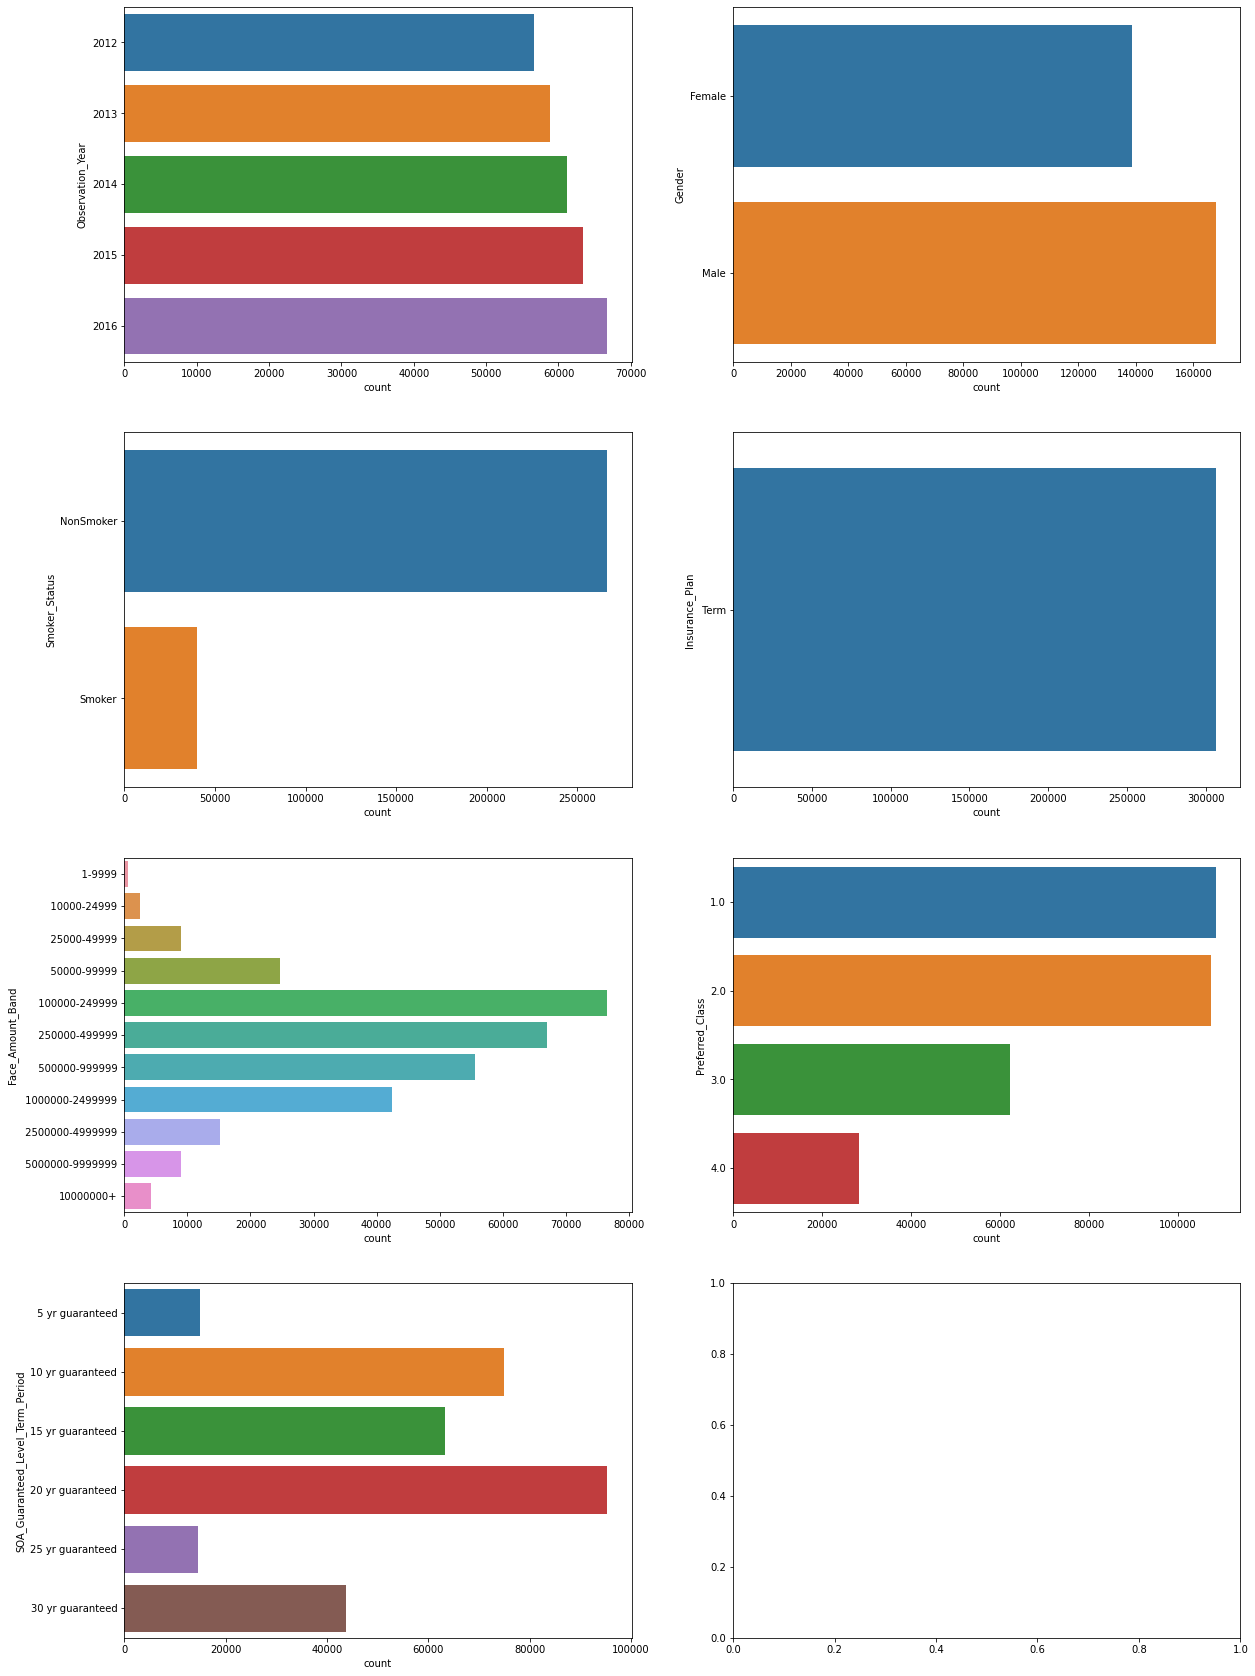

In [8]:
# categorical variables
face_amount_order = ['    1-9999', '   10000-24999', '   25000-49999', '   50000-99999','  100000-249999' , '  250000-499999','  500000-999999',' 1000000-2499999', ' 2500000-4999999',' 5000000-9999999', '10000000+']
term_period_order = [' 5 yr guaranteed', '10 yr guaranteed',  '15 yr guaranteed', '20 yr guaranteed', '25 yr guaranteed','30 yr guaranteed']
fig, ax = plt.subplots(4,2, figsize = (20,30))
ax = ax.flatten()
for i,column in enumerate(['Observation_Year', 'Gender', 'Smoker_Status', 'Insurance_Plan',
       'Face_Amount_Band', 'Preferred_Class',
       'SOA_Guaranteed_Level_Term_Period']):
    if column == 'Face_Amount_Band':
        order = face_amount_order
    elif column == 'SOA_Guaranteed_Level_Term_Period':
        order = term_period_order
    else:
        order = None
    sns.countplot(y = sample_df[column], ax = ax[i], orient = 'h', order = order)
plt.show()


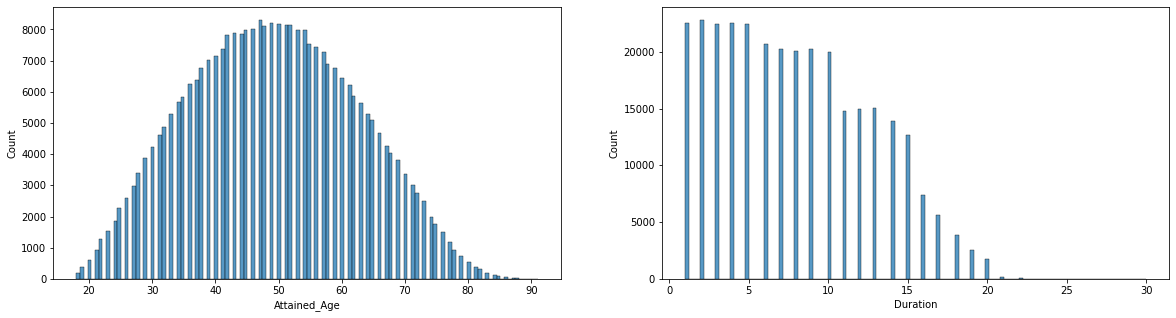

In [9]:
# age and duration variables
fig, ax = plt.subplots(1,2, figsize = (20,5))
sns.histplot(x = sample_df['Attained_Age'], ax = ax[0])

sns.histplot(x = sample_df['Duration'], ax = ax[1])
plt.show()

In [10]:
sample_df.columns

Index(['Observation_Year', 'Gender', 'Smoker_Status', 'Insurance_Plan',
       'Issue_Age', 'Duration', 'Attained_Age', 'Face_Amount_Band',
       'Issue_Year', 'Preferred_Class', 'SOA_Anticipated_Level_Term_Period',
       'SOA_Guaranteed_Level_Term_Period', 'SOA_Post_level_Term_Indicator',
       'Number_Of_Deaths', 'Policies_Exposed',
       'Expected_Death_QX2015VBT_by_Policy', 'mort', 'Observation_Year_2012',
       'Observation_Year_2013', 'Observation_Year_2014',
       'Observation_Year_2015', 'Observation_Year_2016', 'Gender_Female',
       'Gender_Male', 'Smoker_Status_NonSmoker', 'Smoker_Status_Smoker',
       'Face_Amount_Band_    1-9999', 'Face_Amount_Band_   10000-24999',
       'Face_Amount_Band_   25000-49999', 'Face_Amount_Band_   50000-99999',
       'Face_Amount_Band_  100000-249999', 'Face_Amount_Band_  250000-499999',
       'Face_Amount_Band_  500000-999999', 'Face_Amount_Band_ 1000000-2499999',
       'Face_Amount_Band_ 2500000-4999999',
       'Face_Amount_Band_

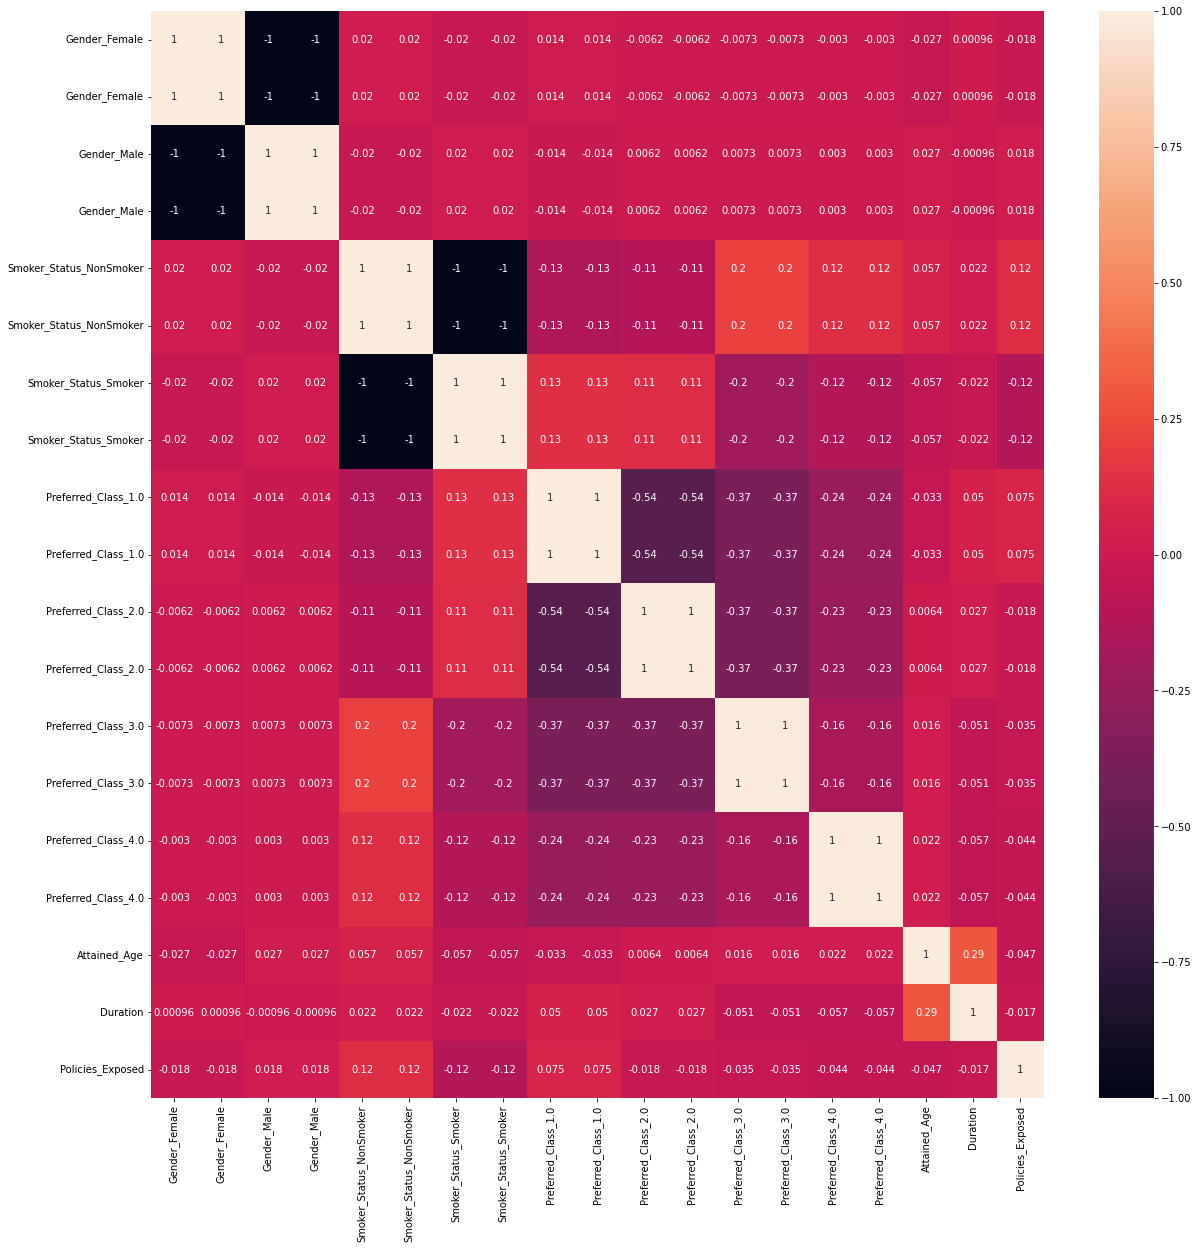

In [11]:
# we quickly check for any collinearity
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(sample_df[['Gender_Female','Gender_Male','Smoker_Status_NonSmoker','Smoker_Status_Smoker','Preferred_Class_1.0','Preferred_Class_2.0','Preferred_Class_3.0','Preferred_Class_4.0','Attained_Age', 'Duration', 'Policies_Exposed']].corr(), annot=True)
plt.show()

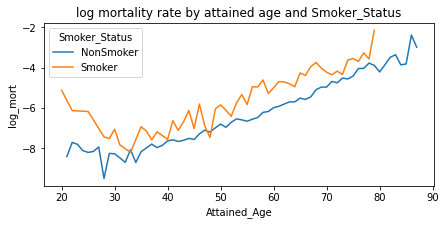

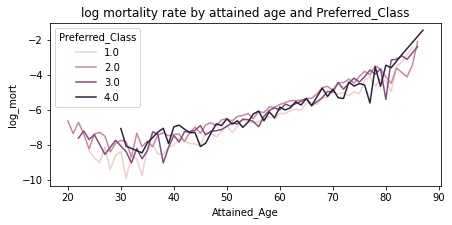

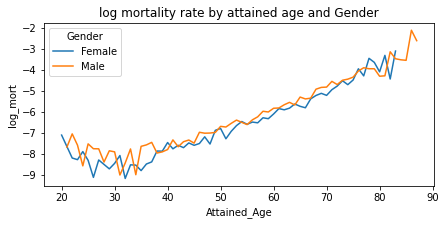

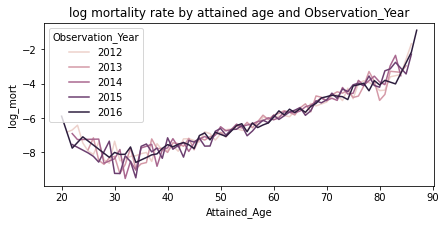

In [12]:
# log mort by Attained Age

def stratify(field):
    fig, ax = plt.subplots(figsize = (7,3))
    temp = sample_df.groupby(['Attained_Age', field])[['Number_Of_Deaths', 'Policies_Exposed']].sum().reset_index()
    temp['log_mort'] = (temp.Number_Of_Deaths / temp.Policies_Exposed).apply(np.log)
    sns.lineplot(data = temp, x = 'Attained_Age', y = 'log_mort', hue = field, ax = ax)
    plt.title(f'log mortality rate by attained age and {field}')
    plt.show()

stratify('Smoker_Status')
stratify('Preferred_Class')
stratify('Gender')
stratify('Observation_Year')


# Modeling

### Train/test split

First we split the data into 80% for training and 20% for testing. 

In this context because we don't really need to do hyperparameter tuning so it's not necessary to create a validation set.

In [16]:
# create training (80%), validation (5%) and test set (15%)
random_seed = 0
train_df = sample_df.sample(frac = 0.8, random_state = random_seed)
test_df = sample_df.loc[~sample_df.index.isin(train_df.index),:]

# add constant variable
train_df['Const'] = 1
test_df['Const'] = 1
 
print(f'Train size: {train_df.shape[0]}, test size: {test_df.shape[0]}')

Train size: 245367, test size: 61342


In [29]:
dataset_columns = [
    'Number_Of_Deaths',
    'Observation_Year',
    'Gender',
    'Smoker_Status',
    'Face_Amount_Band',
    'Preferred_Class',
    'SOA_Anticipated_Level_Term_Period',
    'Attained_Age',
    'Duration'
]

In [30]:
vm_dataset = train_df[dataset_columns]

In [31]:
vm_dataset.to_csv('insurance_dataset.csv', index=False)

In [32]:
train_df['Number_Of_Deaths'].value_counts()

0    241261
1      3809
2       261
3        28
4         7
5         1
Name: Number_Of_Deaths, dtype: int64

### GLM modeling 101

In a generalized linear model (GLM), each outcome Y of the dependent variables is assumed to be generated from a particular distribution in an exponential family, a large class of probability distributions that includes the normal, binomial, Poisson and gamma distributions, among others. The mean, $μ$, of the distribution depends on the independent variables, X, through

<center> ${\displaystyle \operatorname {E} (\mathbf {Y} |\mathbf {X} )={\boldsymbol {\mu }}=g^{-1}(\mathbf {X} {\boldsymbol {\beta }})}$ </center>

where:

- $E(Y|X)$ is the expected value of $Y$ conditional on $X$
- $Xβ$ is the linear predictor, a linear combination of unknown parameters $β$
- $g$ is the link function.

### Model 1: Poisson distribution with log link on count

<i> Target Variable </i> = [Number_Of_Deaths]

<i> Input Variables </i> =  [Observation_Year, Gender, Smoker_Status, Face_Amount_Band, Preferred_Class, Attained_Age, Duration, SOA_Anticipated_Level_Term_Period]

As the <i> target variable</i> is a count measure, we will fit GLM with Poisson distribution and log link. 

The target variable is count, what we really fit the Poisson model to is mortality rate (count/exposure) with the use of offset. This is a common practice according to 
https://en.wikipedia.org/wiki/Poisson_regression

In [17]:
model1 = smf.glm(formula = 'Number_Of_Deaths ~ 1 + C(Observation_Year) + C(Gender) + C(Smoker_Status) + C(Face_Amount_Band) + C(Preferred_Class) + C(SOA_Anticipated_Level_Term_Period) \
                                        + Attained_Age + Duration',
                data = train_df,
                family=sm.families.Poisson(sm.families.links.log()),
                freq_weights = train_df['Policies_Exposed'],
                offset = train_df['Policies_Exposed'].apply(lambda x: np.log(x))
              )
res1 = model1.fit()
res1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       Number_Of_Deaths   No. Observations:               245367
Model:                            GLM   Df Residuals:               3076959.49
Model Family:                 Poisson   Df Model:                           26
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.1671e+05
Date:                Fri, 25 Nov 2022   Deviance:                   9.8487e+05
Time:                        13:39:01   Pearson chi2:                 3.05e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.6359
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    -9.5558      0.189    -50.585      0.000      -9.926      -9.186
C(Observation_Year)[T.2013]                                  -0.0110      0.007     -1.630      0.103      -0.024       0.002
C(Observation_Year)[T.2014]                                  -0.0005      0.006     -0.075      0.940      -0.013       0.012
C(Observation_Year)[T.2015]                                  -0.0415      0.007     -6.161      0.000      -0.055      -0.028
C(Observation_Year)[T.2016]                                  -0.0495      0.007     -7.512      0.000      -0.062      -0.037
C(Gender)[T.Male]                                             0.2836      0.005     60.709      0.000       0.274       0.293
C(Smoker_Status)[T.Smoker]                                    1.0273      0.015     66.496      0.000       0.997       1.058
C(Face_Amount_Band)[T.   10000-24999]                        -0.3526      0.155     -2.276      0.023      -0.656      -0.049
C(Face_Amount_Band)[T.   25000-49999]                        -0.6121      0.155     -3.954      0.000      -0.915      -0.309
C(Face_Amount_Band)[T.   50000-99999]                        -0.6884      0.154     -4.459      0.000      -0.991      -0.386
C(Face_Amount_Band)[T.  100000-249999]                       -1.4426      0.154     -9.364      0.000      -1.745      -1.141
C(Face_Amount_Band)[T.  250000-499999]                       -1.7962      0.154    -11.654      0.000      -2.098      -1.494
C(Face_Amount_Band)[T.  500000-999999]                       -1.8036      0.154    -11.697      0.000      -2.106      -1.501
C(Face_Amount_Band)[T. 1000000-2499999]                      -1.8757      0.154    -12.155      0.000      -2.178      -1.573
C(Face_Amount_Band)[T. 2500000-4999999]                      -1.7323      0.169    -10.240      0.000      -2.064      -1.401
C(Face_Amount_Band)[T. 5000000-9999999]                      -1.3891      0.227     -6.129      0.000      -1.833      -0.945
C(Face_Amount_Band)[T.10000000+]                             -2.1882      0.613     -3.573      0.000      -3.389      -0.988
C(Preferred_Class)[T.2.0]                                     0.4865      0.005     99.710      0.000       0.477       0.496
C(Preferred_Class)[T.3.0]                                     0.4810      0.007     71.804      0.000       0.468       0.494
C(Preferred_Class)[T.4.0]                                     0.4539      0.011     40.066      0.000       0.432       0.476
C(SOA_Anticipated_Level_Term_Period)[T.10 yr anticipated]    -0.0716      0.108     -0.661      0.508      -0.284       0.141
C(SOA_Anticipated_Level_Term_Period)[T.15 yr anticipated]  

In [18]:
def visualize(df, agg_field, title, VBT = False):
    agg = df.groupby(agg_field)['Number_Of_Deaths', 'death_hat', 'Expected_Death_QX2015VBT_by_Policy', 'Policies_Exposed'].sum().reset_index()
    agg['log_mort'] = (agg['Number_Of_Deaths']/agg['Policies_Exposed']).apply(lambda x: np.log(x))
    agg['log_mort_predicted'] = (agg['death_hat']/agg['Policies_Exposed']).apply(lambda x: np.log(x))
    agg['log_mort_VBT'] = (agg['Expected_Death_QX2015VBT_by_Policy']/agg['Policies_Exposed']).apply(lambda x: np.log(x))
    
    #sns.lineplot(data = agg, x = agg_field, y = 'log_mort', hue = hue)
    plt.plot(agg[agg_field], agg['log_mort'], color = 'r')
    plt.plot(agg[agg_field], agg['log_mort_predicted'], color = 'b')
    if VBT:
        plt.plot(agg[agg_field], agg['log_mort_VBT'], color = 'g')
    plt.legend(['log_mort','log_mort_predicted']) 
    plt.xlabel(agg_field)
    plt.ylabel('log_mort')
    plt.title(title)
    plt.show()

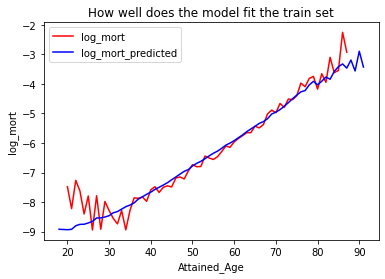

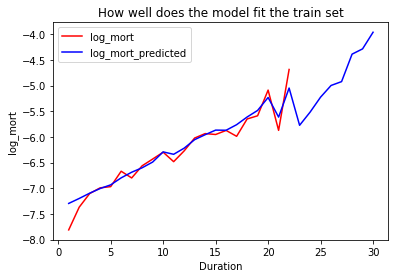

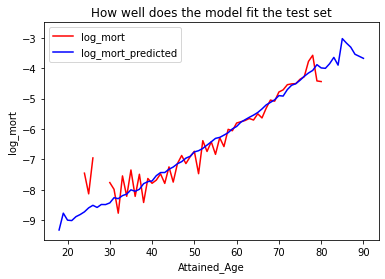

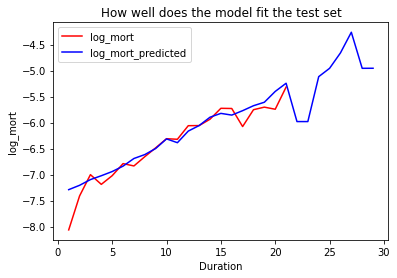

In [19]:
train_df['yhat'] = res1.predict(train_df)
train_df['death_hat'] = train_df['yhat'] * train_df['Policies_Exposed']

test_df['yhat'] = res1.predict(test_df)
test_df['death_hat'] = test_df['yhat']* test_df['Policies_Exposed']

visualize(train_df, 'Attained_Age', 'How well does the model fit the train set')
visualize(train_df, 'Duration', 'How well does the model fit the train set')


visualize(test_df, 'Attained_Age', 'How well does the model fit the test set')
visualize(test_df, 'Duration', 'How well does the model fit the test set')

# Validation


### Goodness of Fit 

#### <i> Pseudo R-squared </i>

In linear regression, the squared multiple correlation, R-squared is often used to assess goodness of fit as it represents the proportion of variance in the criterion that is explained by the predictors.

For GLM, pseudo R-squared is the most analogous measure to the squared multiple correlations. It represents the proportional reduction in the deviance wherein the deviance is treated as a measure of variation analogous but not identical to the variance in linear regression analysis. Quantifiably, the higher is better.

<center> $R_{\text{L}}^{2}={\frac {{Deviance}_{\text{null}}-Deviance_{\text{fitted}}}{Deviance_{\text{null}}}}$ </center>



In [20]:
res1.pseudo_rsquared()

0.6358929941251608

#### <i> Deviance </i>

The (total) deviance for a model M with estimates ${\displaystyle {\hat {\mu }}=E[Y|{\hat {\theta }}_{0}]}$, based on a dataset y, may be constructed by its likelihood as:

<center> ${\displaystyle D(y,{\hat {\mu }})=2\left(\log \left[p(y\mid {\hat {\theta }}_{s})\right]-\log \left[p(y\mid {\hat {\theta }}_{0})\right]\right)}$ </center>

Here $\hat \theta_0$ denotes the fitted values of the parameters in the model M, while $\hat \theta_s$ denotes the fitted parameters for the saturated model: both sets of fitted values are implicitly functions of the observations y.

In large samples, deviance follows a chi-square distribution with n−p degrees of freedom, where n is the number of observations and p is the number of parameters in the model. The null hypothesis, H0, is that the model fits. The alternative hypothesis, H1, is that the model does not fit. A deviance much higher than n−p indicates the model is a poor fit to the data. Quantifiably, smaller is always better: The smaller the deviance, the better the fit of the model.

Here we divided the `deviance` by the `residual degree of freedom` and observed a ratio much smaller than 1

In [21]:
res1.deviance/res1.df_resid

0.32007802295856785

#### <i> Pearson Statistic and dispersion </i>


Similar to `deviance` test, the `Pearson Statistic` is approximately chi-square distributed with n – p degrees of freedom. A Pearson Statistic much higher than the degree of freedom indicates that the model is a poor fit.

Additionally, for a Poisson distribution, the mean and the variance are equal. In addition to testing goodness-of-fit, the Pearson statistic can also be used as a test of overdispersion. <b>Overdispersion</b> means that the actual covariance matrix for the observed data exceeds that for the specified model for Y|X. 

Here we divided the `pearson statistic` by the `residual degree of freedom` and observed a value very close to 1

In [22]:
res1.pearson_chi2/res1.df_resid

0.9914231547483463

### Feature importance

#### <i>Confidence intervals and p-values </i>

Confidence intervals and p-values quantifying the statistical significance of individual predictor variables. Unlike other models like XGBoost, the estimates for statistical significance of individual predictor variables are readily available. 

In [23]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       Number_Of_Deaths   No. Observations:               245367
Model:                            GLM   Df Residuals:               3076959.49
Model Family:                 Poisson   Df Model:                           26
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.1671e+05
Date:                Fri, 25 Nov 2022   Deviance:                   9.8487e+05
Time:                        18:06:56   Pearson chi2:                 3.05e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.6359
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    -9.5558      0.189    -50.585      0.000      -9.926      -9.186
C(Observation_Year)[T.2013]                                  -0.0110      0.007     -1.630      0.103      -0.024       0.002
C(Observation_Year)[T.2014]                                  -0.0005      0.006     -0.075      0.940      -0.013       0.012
C(Observation_Year)[T.2015]                                  -0.0415      0.007     -6.161      0.000      -0.055      -0.028
C(Observation_Year)[T.2016]                                  -0.0495      0.007     -7.512      0.000      -0.062      -0.037
C(Gender)[T.Male]                                             0.2836      0.005     60.709      0.000       0.274       0.293
C(Smoker_Status)[T.Smoker]                                    1.0273      0.015     66.496      0.000       0.997       1.058
C(Face_Amount_Band)[T.   10000-24999]                        -0.3526      0.155     -2.276      0.023      -0.656      -0.049
C(Face_Amount_Band)[T.   25000-49999]                        -0.6121      0.155     -3.954      0.000      -0.915      -0.309
C(Face_Amount_Band)[T.   50000-99999]                        -0.6884      0.154     -4.459      0.000      -0.991      -0.386
C(Face_Amount_Band)[T.  100000-249999]                       -1.4426      0.154     -9.364      0.000      -1.745      -1.141
C(Face_Amount_Band)[T.  250000-499999]                       -1.7962      0.154    -11.654      0.000      -2.098      -1.494
C(Face_Amount_Band)[T.  500000-999999]                       -1.8036      0.154    -11.697      0.000      -2.106      -1.501
C(Face_Amount_Band)[T. 1000000-2499999]                      -1.8757      0.154    -12.155      0.000      -2.178      -1.573
C(Face_Amount_Band)[T. 2500000-4999999]                      -1.7323      0.169    -10.240      0.000      -2.064      -1.401
C(Face_Amount_Band)[T. 5000000-9999999]                      -1.3891      0.227     -6.129      0.000      -1.833      -0.945
C(Face_Amount_Band)[T.10000000+]                             -2.1882      0.613     -3.573      0.000      -3.389      -0.988
C(Preferred_Class)[T.2.0]                                     0.4865      0.005     99.710      0.000       0.477       0.496
C(Preferred_Class)[T.3.0]                                     0.4810      0.007     71.804      0.000       0.468       0.494
C(Preferred_Class)[T.4.0]                                     0.4539      0.011     40.066      0.000       0.432       0.476
C(SOA_Anticipated_Level_Term_Period)[T.10 yr anticipated]    -0.0716      0.108     -0.661      0.508      -0.284       0.141
C(SOA_Anticipated_Level_Term_Period)[T.15 yr anticipated]  

From the summary, we can see that all of the features other than `SOA_Anticipated_Level_Term_Period` are significant as all p-values are < 5%. 

Directionally, the coeficients for the main features like `Gender`, `Smoking Status`, `Attained_Age` or `Duration` are all aligned with our intuition and the EDA charts that we created previously:

- Mortality rate for Male is higher than Female
- Mortality rate for Smoker is higher than non-Smoker
- Mortality rate is higher as age is higher
- Mortality rate is higher as duration is longer


### Interaction Effects

One of the key elements in understanding a predictive model is examining its interaction effects. Interaction effects occur when the impact of a change in a variable depends on the values of other features. 

So we fit a model with all interactions between variables and compare the results against our Vanilla model.

#### <i> Model 2: Poisson distribution with log link on Death Count with interactions </i>

In [24]:
model2 = smf.glm(formula = 'Number_Of_Deaths ~ 1 + C(Observation_Year) + C(Gender) + C(Smoker_Status) + C(Face_Amount_Band) + C(Preferred_Class) +  Attained_Age + Duration\
                        + C(Observation_Year) * (C(Gender) + C(Smoker_Status) + C(Face_Amount_Band) + C(Preferred_Class) + Attained_Age + Duration) + C(Gender) * (C(Smoker_Status) + C(Face_Amount_Band) + C(Preferred_Class) + Attained_Age + Duration) + C(Smoker_Status) * (C(Face_Amount_Band) + C(Preferred_Class) + Attained_Age + Duration) + C(Face_Amount_Band) * (C(Preferred_Class) + Attained_Age + Duration) + C(Preferred_Class) * (Attained_Age + Duration) + Attained_Age * Duration',
                data = train_df,
                family=sm.families.Poisson(sm.families.links.log()),
                freq_weights = train_df['Policies_Exposed'],
                offset = train_df['Policies_Exposed'].apply(lambda x: np.log(x))
              )
res2 = model2.fit() #_regularized(method='elastic_net', alpha=0.5)
res2.summary()


ValueError: NaN, inf or invalid value detected in weights, estimation infeasible.

#### <i> Compared to the vanilla model </i>

First, pearson and deviance are reasonable

In [21]:
print(f'Pearson_statistics/df = {res2.pearson_chi2/res2.df_resid}')

print(f'deviance/df = {res2.deviance/res2.df_resid}')


Pearson_statistics/df = 1.0390677374359132
deviance/df = 0.31581200862903164


Compared against model 1, we noticed a siginificant reduction on AIC so model 2 has a better fit, but the trade off is a more convoluted set of features. 

In [22]:
print(f'AIC for Model 1 - No interaction: {res1.aic}')
print(f'AIC for Model 2 - With interactions: {res2.aic}')


AIC for Model 1 - No interaction: 1433477.565949843
AIC for Model 2 - With interactions: 1420602.156667149


<b>Side note on definition of AIC: </b> A collection of candidate models can be compared, and the selection criteria may be to choose the model with the highest log-likelihood. However, the log-likelihood of a model will almost always increase with the addition of more variables, even if those variables are insignificant and do little to increase the model’s predictive power. The Akaike information criterion, or AIC, is a penalized log-likelihood formula that charges a penalty for additional variables. It can be thought of as a measure of the relative quality of a model. When considering one or more models fit to the same dataset, the preferred model is the one with the minimum AIC value.

### Correlated Features



For GLMs and other variations of linear models, correlation, multicollinearity, and aliasing (perfect correlation) among predictor variables can cause standard deviations of coefficients to be large and coefficients to behave erratically, causing issues with interpretability.

This is usually assessed by looking at the correlation matrix, which we have seen during the EDA phase. Let's show it again below. We don't see severe correlation between any two features that requires dropping one from the feature set.

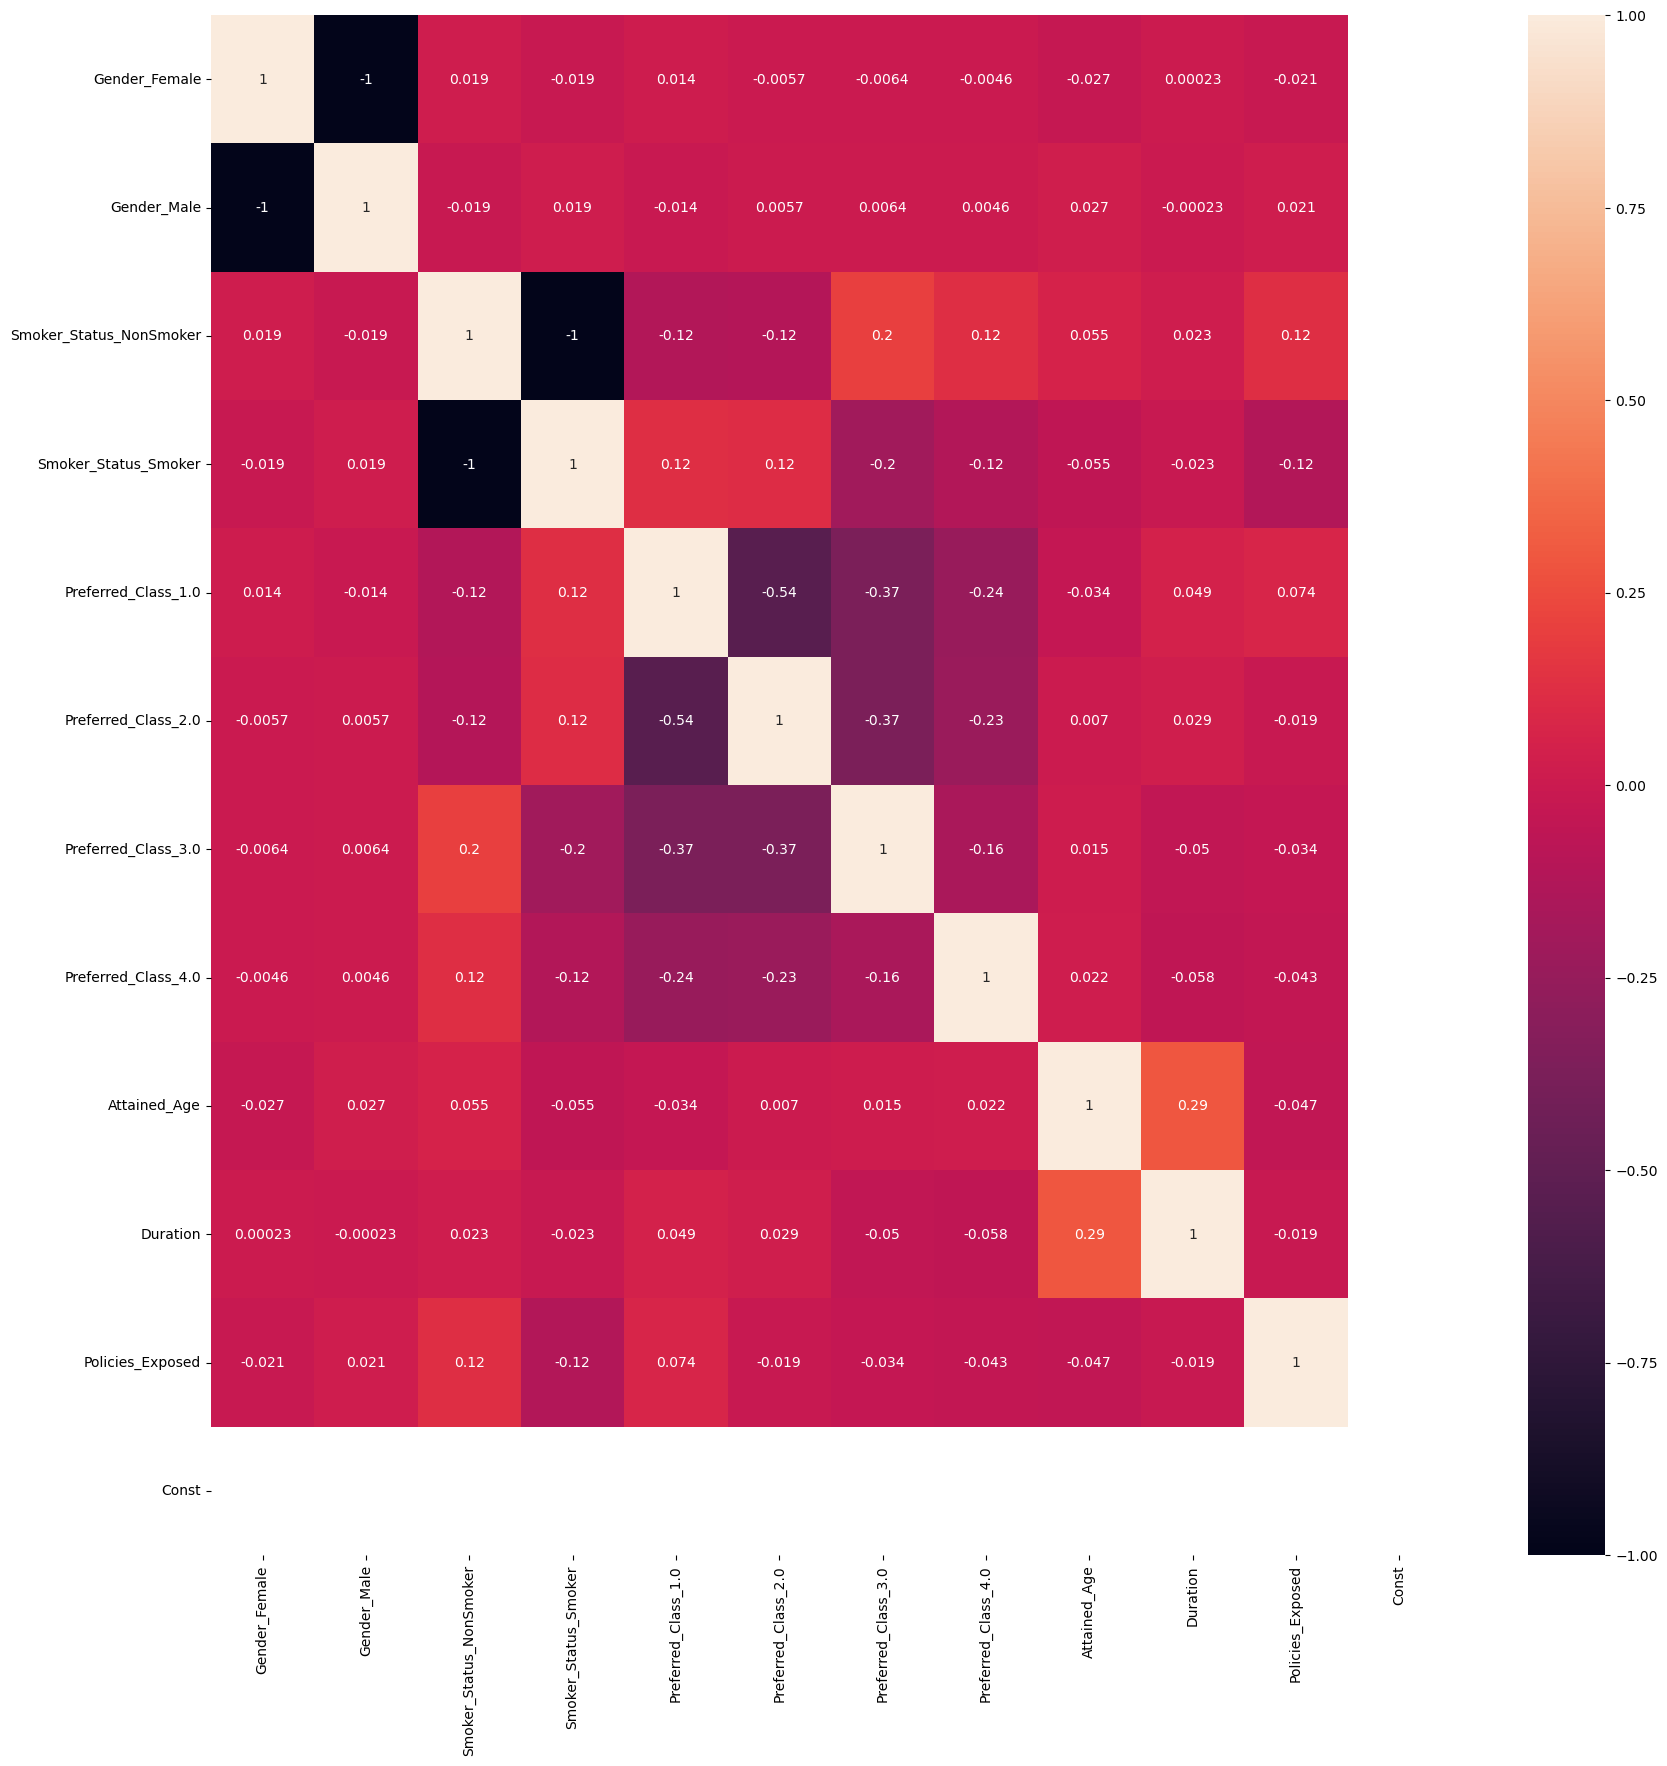

In [23]:
# we quickly check for any collinearity
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(train_df[['Gender_Female','Gender_Male','Smoker_Status_NonSmoker','Smoker_Status_Smoker','Preferred_Class_1.0','Preferred_Class_2.0','Preferred_Class_3.0','Preferred_Class_4.0','Attained_Age', 'Duration', 'Policies_Exposed', 'Const']].corr(), annot=True)
plt.show()

# Conclusion

# References

[1] https://scikit-learn.fondation-inria.fr/generalized-linear-models-have-landed-in-scikit-learn/

[2] https://www.statsmodels.org/stable/index.html

[3] Mortality Data: https://www.soa.org/resources/research-reports/2021/2009-2016-individual-life-insurance-mortality/

[4] https://statmath.wu.ac.at/courses/heather_turner/index.html

[5] https://sscc.wisc.edu/sscc/pubs/glm-r/index.html#glm-families

[6] http://www.jtrive.com/goodness-of-fit-and-significance-testing-for-logistic-regression-models.html

# Appendix

### Model 3: Gaussian distribution with log link on mortality rate

In [24]:
model2 = smf.glm(formula = 'mort ~ 1 + C(Observation_Year) + C(Gender) + C(Smoker_Status) + C(Face_Amount_Band) + C(Preferred_Class) + Attained_Age + Duration', 
                 data = train_df,
                 family=sm.families.Gaussian(link = sm.families.links.log()),
                 freq_weights = train_df['Policies_Exposed'])
res2 = model2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   mort   No. Observations:               245367
Model:                            GLM   Df Residuals:               3076964.49
Model Family:                Gaussian   Df Model:                           21
Link Function:                    log   Scale:                      0.00012672
Method:                          IRLS   Log-Likelihood:             9.4397e+06
Date:                Wed, 23 Nov 2022   Deviance:                       389.92
Time:                        00:17:01   Pearson chi2:                     390.
No. Iterations:                    16   Pseudo R-squ. (CS):             0.4121
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 -11.0932      0.034   -325.134      0.000     -11.160     -11.026
C(Observation_Year)[T.2013]                 0.1630      0.008     19.843      0.000       0.147       0.179
C(Observation_Year)[T.2014]                 0.2005      0.008     24.990      0.000       0.185       0.216
C(Observation_Year)[T.2015]                 0.0986      0.008     11.808      0.000       0.082       0.115
C(Observation_Year)[T.2016]                 0.0923      0.008     11.317      0.000       0.076       0.108
C(Gender)[T.Male]                           0.2783      0.005     51.547      0.000       0.268       0.289
C(Smoker_Status)[T.Smoker]                  0.9238      0.008    122.717      0.000       0.909       0.939
C(Face_Amount_Band)[T.   10000-24999]      -0.2710      0.026    -10.557      0.000      -0.321      -0.221
C(Face_Amount_Band)[T.   25000-49999]      -0.3074      0.025    -12.107      0.000      -0.357      -0.258
C(Face_Amount_Band)[T.   50000-99999]      -0.7858      0.025    -31.070      0.000      -0.835      -0.736
C(Face_Amount_Band)[T.  100000-249999]     -0.9710      0.025    -39.096      0.000      -1.020      -0.922
C(Face_Amount_Band)[T.  250000-499999]     -1.2303      0.026    -48.119      0.000      -1.280      -1.180
C(Face_Amount_Band)[T.  500000-999999]     -1.3014      0.027    -48.565      0.000      -1.354      -1.249
C(Face_Amount_Band)[T. 1000000-2499999]    -1.3628      0.029    -47.226      0.000      -1.419      -1.306
C(Face_Amount_Band)[T. 2500000-4999999]    -1.4584      0.061    -23.916      0.000      -1.578      -1.339
C(Face_Amount_Band)[T. 5000000-9999999]    -1.0541      0.062    -16.887      0.000      -1.176      -0.932
C(Face_Amount_Band)[T.10000000+]           -2.2859      0.326     -7.003      0.000      -2.926      -1.646
C(Preferred_Class)[T.2.0]                   0.4147      0.007     60.599      0.000       0.401       0.428
C(Preferred_Class)[T.3.0]                   0.4264      0.008     52.582      0.000       0.410       0.442
C(Preferred_Class)[T.4.0]                   0.3780      0.011     34.956      0.000       0.357       0.399
Attained_Age                                0.0877      0.000    280.772      0.000       0.087       0.088
Duration                                    0.0400      0.001     72.956      0.000       0.039       0.041
===========================================================================================================
"""

In [25]:
# append fitted values for training and predicted values for testing

train_df['mort_hat'] = res2.mu
train_df['death_hat'] = train_df['mort_hat'] * train_df['Policies_Exposed']
test_df['mort_hat'] = res2.predict(exog = test_df)
test_df['death_hat'] = test_df['mort_hat'] * test_df['Policies_Exposed']

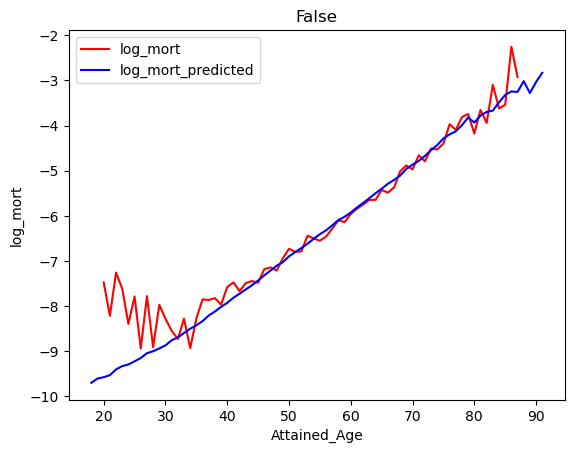

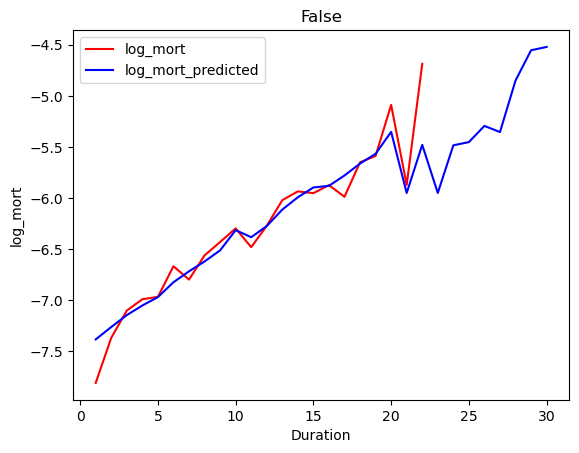

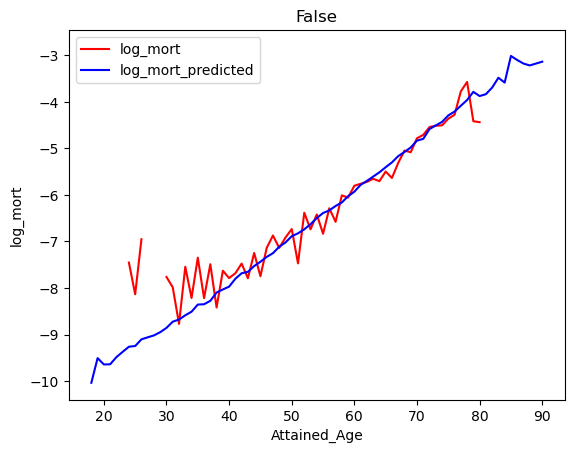

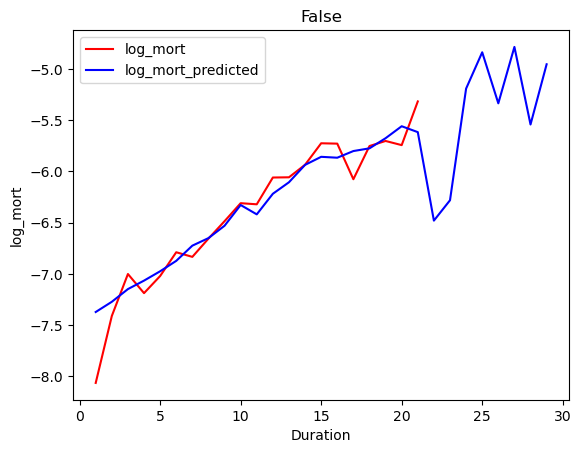

In [26]:
visualize(train_df, 'Attained_Age', False)
visualize(train_df, 'Duration', False)

visualize(test_df, 'Attained_Age', False)
visualize(test_df, 'Duration', False)

### Model 1 not using formula

In [27]:
# Target Variable
Y = ['Number_Of_Deaths']

# Predictors (aka Input Variables)
X = cat_vars_encoded + ['Attained_Age', 'Duration',  'Const'] #'Policies_Exposed',

# Our choice for Link function is the Gaussian distribution for the nature of death frequency
model = sm.GLM(endog = train_df[Y], 
               exog = train_df[X], 
               family=sm.families.Poisson(sm.families.links.log()),
               freq_weights = train_df['Policies_Exposed'],
               offset = train_df['Policies_Exposed'].apply(lambda x: np.log(x))
              )
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       Number_Of_Deaths   No. Observations:               245367
Model:                            GLM   Df Residuals:               3076959.49
Model Family:                 Poisson   Df Model:                           26
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.1671e+05
Date:                Wed, 23 Nov 2022   Deviance:                   9.8487e+05
Time:                        00:17:18   Pearson chi2:                 3.05e+06
No. Iterations:                   100   Pseudo R-squ. (CS):             0.6359
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Observation_Year_2012                                  -0.7061      0.006   -112.048      0.000      -0.718      -0.694
Observation_Year_2013                                  -0.7171      0.006   -115.291      0.000      -0.729      -0.705
Observation_Year_2014                                  -0.7066      0.006   -116.606      0.000      -0.718      -0.695
Observation_Year_2015                                  -0.7476      0.006   -120.062      0.000      -0.760      -0.735
Observation_Year_2016                                  -0.7556      0.006   -122.532      0.000      -0.768      -0.744
Gender_Female                                          -1.9584      0.012   -166.487      0.000      -1.981      -1.935
Gender_Male                                            -1.6747      0.012   -140.401      0.000      -1.698      -1.651
Smoker_Status_NonSmoker                                -2.3302      0.013   -174.912      0.000      -2.356      -2.304
Smoker_Status_Smoker                                   -1.3029      0.015    -89.578      0.000      -1.331      -1.274
Face_Amount_Band_    1-9999                             0.9316      0.151      6.182      0.000       0.636       1.227
Face_Amount_Band_   10000-24999                         0.5790      0.059      9.884      0.000       0.464       0.694
Face_Amount_Band_   25000-49999                         0.3195      0.058      5.503      0.000       0.206       0.433
Face_Amount_Band_   50000-99999                         0.2432      0.057      4.261      0.000       0.131       0.355
Face_Amount_Band_  100000-249999                       -0.5110      0.056     -9.086      0.000      -0.621      -0.401
Face_Amount_Band_  250000-499999                       -0.8646      0.056    -15.363      0.000      -0.975      -0.754
Face_Amount_Band_  500000-999999                       -0.8720      0.056    -15.469      0.000      -0.983      -0.762
Face_Amount_Band_ 1000000-2499999                      -0.9441      0.057    -16.681      0.000      -1.055      -0.833
Face_Amount_Band_ 2500000-4999999                      -0.8006      0.085     -9.463      0.000      -0.966      -0.635
Face_Amount_Band_ 5000000-9999999                      -0.4575      0.161     -2.842      0.004      -0.773      -0.142
Face_Amount_Band_10000000+                             -1.2566      0.541     -2.322      0.020      -2.317      -0.196
Preferred_Class_1.0                                    -1.2636      0.007   -180.065      0.000      -1.277      -1.250
Preferred_Class_2.0                                    -0.7771      0.007   -112.469      0.000      -0.791      -0.764
Preferred_Class_3.0                                    -0.7826      0.008   -101.60